# Extract boxes with PyTorch

In [1]:
%load_ext autoreload
%autoreload 2

import os, glob, json, tqdm, pandas
import matplotlib.pyplot as plt
%pylab inline

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import Adam

from imgaug import augmenters as iaa
from imgaug import imgaug as ia
from PIL import Image

from IPython.display import display

from prepare_images_utils import *
from latex_dataset import *

Populating the interactive namespace from numpy and matplotlib


## Prepare data source

In [2]:
SRC_DIR = '/notebook/generated/src/'

In [3]:
all_image_ids = [os.path.basename(fname)[:-9]
                 for fname in glob.glob(os.path.join(SRC_DIR, '*_out.json'))]
random.shuffle(all_image_ids)

TOTAL_SAMPLES = len(all_image_ids)
TRAIN_SAMPLES = int(TOTAL_SAMPLES * 0.8)
VAL_SAMPLES = TOTAL_SAMPLES - TRAIN_SAMPLES
train_image_ids = all_image_ids[:TRAIN_SAMPLES]
val_image_ids = all_image_ids[TRAIN_SAMPLES:]

In [4]:
def load_image_with_boxes(img_id):
    img = load_image_opaque(os.path.join(SRC_DIR, img_id + '_in.png'))
    with open(os.path.join(SRC_DIR, img_id + '_out.json'), 'r') as f:
        boxes = json.load(f)
    return img, boxes


def prepare_img_boxes_for_nn(img, boxes, shape=(600, 600)):
    cats, just_boxes = zip(*boxes)
    cats = numpy.array(cats)
    just_boxes = numpy.array(just_boxes) * POINTS_TO_PIXELS_FACTOR
    just_boxes = just_boxes[:, [1, 0, 3, 2]] # x1, y1, x2, y2
    cropbox = numpy.array((just_boxes[:, 0].min(),
                           just_boxes[:, 1].min(),
                           just_boxes[:, 2].max(),
                           just_boxes[:, 3].max()))

    res_in_img = Image.new('L', shape, 255)
    res_in_img.paste(img.crop(cropbox))

    just_boxes -= cropbox[[0, 1, 0, 1]]
    just_boxes = numpy.clip(just_boxes,
                            (0, 0, 0, 0),
                            (shape[0], shape[1], shape[0], shape[1]))
    boxes_area = (just_boxes[:, 2] - just_boxes[:, 0]) * (just_boxes[:, 3] - just_boxes[:, 1])
    good_boxes = numpy.where(boxes_area > 0)[0]
    return (numpy.array(res_in_img).astype('float32') / 255,
            cats[good_boxes],
            just_boxes[good_boxes])


TOTAL_CLASSES = 5
def make_mask_for_nn(size, box_cats, boxes_on_image):
    result = numpy.zeros((TOTAL_CLASSES, ) + size, dtype='float32')
    for cat, bbox in zip(box_cats, boxes_on_image.bounding_boxes):
        result[cat, int(bbox.y1):int(bbox.y2+1), int(bbox.x1):int(bbox.x2+1)] = 1
    return result


def calc_loss_weights(mask, edge_add_weight=0.5, laplacian_ksize=5):
    result = numpy.ones_like(mask)
    for sample_i in range(mask.shape[0]):
        for channel_i in range(mask.shape[1]):
            edges = numpy.absolute(cv2.Laplacian(mask[sample_i, channel_i],
                                                 cv2.CV_32F,
                                                 ksize=laplacian_ksize))
            if edges.max() > 0:
                result[sample_i, channel_i] += (edge_add_weight * edges / edges.max())
    return result
    


def data_gen(image_ids, augmenter, batch_size=32):
    while True:
        batch_image_ids = numpy.random.choice(image_ids, size=batch_size)
        images, box_cats, boxes = zip(*[prepare_img_boxes_for_nn(*load_image_with_boxes(img_id))
                                        for img_id in batch_image_ids])

        det = augmenter.to_deterministic() if not augmenter.deterministic else augseq

        images_aug = det.augment_images(images)

        boxes = [ia.BoundingBoxesOnImage([ia.BoundingBox(*box)
                                          for box in img_boxes],
                                         img.shape)
                 for img, img_boxes in zip(images, boxes)]
        boxes_aug = det.augment_bounding_boxes(boxes)
        
        mask = numpy.array([make_mask_for_nn(img.shape, img_box_cats, img_boxes)
                            for img, img_box_cats, img_boxes
                            in zip(images_aug, box_cats, boxes_aug)])
        yield (batch_image_ids,
               numpy.expand_dims(numpy.array(images_aug), 1),
               mask,
               calc_loss_weights(mask),
               boxes_aug)

In [5]:
imgaug_pipeline = iaa.Sequential([
#     iaa.Fliplr(0.5), # horizontally flip 50% of the images
#     iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

## Define a network

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilations=[1], padding=1, bn=True):
        super(ConvBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels,
                                              out_channels,
                                              kernel_size,
                                              padding=padding,
                                              dilation=dil)
                                    for dil in dilations])

    def forward(self, x):
        x = self.bn(x)
        return F.relu(torch.cat([conv(x) for conv in self.convs], dim=1))


class UNet(nn.Module):
    def __init__(self, out_channels=TOTAL_CLASSES, first_conv_channels=4, depth=2, out_layers=1, conv_kernel=(3, 3),
                 enc_dilations=[1], dec_dilations=[1]):
        super(UNet, self).__init__()
        enc_channels = [1] + [first_conv_channels * (2**step) for step in range(depth)]
        self.encoder = nn.ModuleList([ConvBlock(enc_channels[i],
                                                enc_channels[i+1],
                                                conv_kernel,
                                                dilations=enc_dilations)
                                      for i in range(depth)])
        bottleneck_channels = enc_channels[-1] * 2
        self.bottleneck = ConvBlock(enc_channels[-1],
                                    bottleneck_channels,
                                    conv_kernel,
                                    dilations=enc_dilations)
        dec_channels = [bottleneck_channels] + enc_channels[:0:-1]
        self.dec_conv = nn.ModuleList([ConvBlock(dec_channels[i],
                                                 dec_channels[i+1],
                                                 conv_kernel,
                                                 dilations=dec_dilations)
                                      for i in range(depth)])
        self.dec_deconv = nn.ModuleList([nn.ConvTranspose2d(dec_channels[i],
                                                            dec_channels[i+1],
                                                            (2, 2),
                                                            stride=2)
                                         for i in range(depth)])
        self.out_layers = nn.ModuleList([ConvBlock(dec_channels[-1],
                                                   dec_channels[-1],
                                                   conv_kernel,
                                                   dilations=dec_dilations)])
        self.out_conv = nn.Conv2d(dec_channels[-1],
                                  out_channels,
                                  (1, 1))

    def forward(self, x):
        enc_conv_outs = []
        enc_pool_outs = [x]
        for enc_conv in self.encoder:
            cur_conv_out = enc_conv(enc_pool_outs[-1])
            enc_conv_outs.append(cur_conv_out)
            cur_pool_out = F.max_pool2d(cur_conv_out, (2, 2))
            enc_pool_outs.append(cur_pool_out)

        cur_out = self.bottleneck(enc_pool_outs[-1])

        for dec_step, (dec_conv, dec_deconv) in enumerate(zip(self.dec_conv, self.dec_deconv)):
            up = dec_deconv(cur_out)
            cur_out = torch.cat([up, enc_conv_outs[-dec_step-1]], dim=1)
            cur_out = dec_conv(cur_out)

        for out_layer in self.out_layers:
            cur_out = F.relu(out_layer(cur_out))

        return F.sigmoid(self.out_conv(cur_out))

## Define losses and metrics

In [7]:
DICE_SMOOTH = 1.0
def dice_coef(pred, target):
    intersection = pred * target
    union = pred + target
    return ((2. * intersection.sum(3).sum(2).sum(0) + DICE_SMOOTH) /
            (union.sum(3).sum(2).sum(0) + DICE_SMOOTH))


def dice_loss(pred, target):
    intersection = pred * target
    union = pred + target
    return 1 - ((2. * intersection.sum() + DICE_SMOOTH) /
                (union.sum() + DICE_SMOOTH))


def px_precision(pred, target, threshold=0.5):
    pred = pred >= threshold
    target = target >= threshold
    tp = (pred * target).float().sum(3).sum(2).sum(0)
    fp = ((target - pred) < 0).float().sum(3).sum(2).sum(0)
    denum = tp + fp
    return tp / (denum + (denum == 0).float())


def px_recall(pred, target, threshold=0.5):
    pred = pred >= threshold
    target = target >= threshold
    tp = (pred * target).float().sum(3).sum(2).sum(0)
    fn = ((pred - target) < 0).float().sum(3).sum(2).sum(0)
    denum = tp + fn
    return tp / (denum + (denum == 0).float())


def make_single_channel(f, channel):
    def _impl(pred, target):
        return f(pred[:, channel:channel+1], target[:, channel:channel+1])
    return _impl


def make_cpu(f):
    def _impl(pred, target):
        return f(pred.cpu(), target.cpu())
    return _impl


METRICS = {'d' : dice_coef,
           'p' : px_precision,
           'r' : px_recall }
# for channel in range(1, TOTAL_CLASSES):
#     METRICS['d{}'.format(channel)] = make_single_channel(make_cpu(dice_coef), channel)
#     METRICS['pp{}'.format(channel)] = make_single_channel(px_precision, channel)
#     METRICS['pr{}'.format(channel)] = make_single_channel(px_recall, channel)

## Train

In [8]:
def mcuda(x, cuda):
    return x.cuda() if cuda else x


def npten(arr, cuda):
    return mcuda(torch.from_numpy(arr), cuda)


def npvar(arr, cuda):
    return mcuda(Variable(torch.from_numpy(arr)), cuda)


def run_network(network, generator, num_batches, optimizer=None, cuda=True):
    metrics = []
    gen_iter = iter(generator)
    for _ in tqdm.tqdm(range(num_batches)):
        image_ids, images, mask, loss_weights, boxes = next(gen_iter)
        mask_var = npvar(mask, cuda)
        loss_weights_var = npvar(loss_weights, cuda)

        cur_out = network(npvar(images, cuda))

        loss = dice_loss(cur_out, mask_var)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm(network.parameters(), 10)
            optimizer.step()

        cur_metrics = { 'loss' : loss.data[0] }
        for name, func in METRICS.items():
            metric_value = func(cur_out, mask_var).cpu().data.numpy()
            cur_metrics.update((name+str(i), v) for i, v in enumerate(metric_value))
        metrics.append(cur_metrics)
    return metrics

In [9]:
EPOCHS_NUM = 30
BATCHES_PER_EPOCH_TRAIN = 100
BATCHES_PER_EPOCH_VAL = 10

BATCH_SIZE = 8
train_gen = data_gen(train_image_ids, imgaug_pipeline, batch_size=BATCH_SIZE)
val_gen = data_gen(val_image_ids, imgaug_pipeline, batch_size=BATCH_SIZE)

net = UNet(first_conv_channels=
           8, depth=3, enc_dilations=[1]).cuda()
optimizer = Adam(net.parameters())
print('total parameters', sum(numpy.product(p.size()) for p in net.parameters()))

train_metrics = []
val_metrics = []
for epoch in range(EPOCHS_NUM):
    print('epoch', epoch)
    net.train()
    cur_train_metrics = run_network(net, train_gen, BATCHES_PER_EPOCH_TRAIN,
                                    optimizer=optimizer)
    train_metrics.extend(cur_train_metrics)
    display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

    net.eval()
    cur_val_metrics = run_network(net, val_gen, BATCHES_PER_EPOCH_VAL)
    val_metrics.extend(cur_val_metrics)
    display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])

  0%|          | 0/100 [00:00<?, ?it/s]

total parameters 60423
epoch 0


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,6.513479e-07,0.352362,0.161223,0.272946,0.295614,0.770363,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,5.338472e-08,0.083773,0.042638,0.070925,0.073757,0.059318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,8.387930e-07,0.532875,0.248177,0.424521,0.430707,0.644832,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,1.651354e-08,0.036760,0.015923,0.011116,0.036518,0.025164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.000005,0.828031,0.442369,0.608366,0.673430,0.397598,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000005,0.156128,0.125723,0.085226,0.169097,0.158276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,2.378706e-05,0.973479,0.781805,0.693531,0.889567,0.156517,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,4.026606e-07,0.008649,0.005709,0.033414,0.019645,0.010404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 2


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.000070,0.970907,0.907512,0.680743,0.898305,0.137543,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000035,0.009523,0.036978,0.029152,0.019825,0.016600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.000131,0.975617,0.938751,0.677139,0.910418,0.125661,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000003,0.008573,0.003001,0.038628,0.011504,0.008682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 3


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.000218,0.974063,0.947049,0.680435,0.911007,0.123626,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000061,0.006937,0.006183,0.032229,0.013489,0.009531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.000302,0.976657,0.951169,0.694563,0.909719,0.119090,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000006,0.011027,0.002969,0.039758,0.014966,0.013227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 4


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.000325,0.975894,0.957735,0.688514,0.913297,0.118320,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000077,0.008133,0.005042,0.030371,0.012658,0.010184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.000389,0.979449,0.961278,0.721314,0.914609,0.105226,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000022,0.007550,0.002973,0.028369,0.009865,0.007873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 5


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.000427,0.977239,0.954911,0.85120,0.915435,0.072256,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000137,0.007558,0.005852,0.04794,0.011767,0.012821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.000535,0.970606,0.959650,0.870107,0.913631,0.069767,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000029,0.016042,0.003966,0.020770,0.017757,0.014673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 6


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.000758,0.975161,0.962035,0.894124,0.914391,0.062873,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000160,0.007660,0.004533,0.012082,0.012158,0.007382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.001088,0.975274,0.963931,0.900810,0.909397,0.062771,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000057,0.011772,0.003414,0.014654,0.015052,0.011002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 7


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.001140,0.977151,0.965633,0.901930,0.916897,0.059237,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000231,0.007914,0.004215,0.010505,0.012367,0.007670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.000158,0.978276,0.963954,0.910304,0.900686,0.064931,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000006,0.005384,0.003774,0.011406,0.010642,0.004727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 8


100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.001447,0.978045,0.966749,0.906948,0.915198,0.058304,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000293,0.007150,0.003607,0.012304,0.013775,0.007679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.001612,0.978286,0.966840,0.903009,0.913015,0.059501,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000040,0.008965,0.004284,0.011464,0.019296,0.010800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 9


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.001927,0.977514,0.968683,0.909657,0.915945,0.057382,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000382,0.006580,0.004206,0.011220,0.011749,0.006376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.003249,0.979760,0.970185,0.913906,0.916260,0.055362,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000177,0.005907,0.001999,0.014614,0.009251,0.006182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 10


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.002387,0.978192,0.969300,0.912840,0.917661,0.055875,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000584,0.007821,0.003848,0.012027,0.011708,0.007272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.001164,0.300052,0.967446,0.229024,0.270930,0.704558,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000038,0.054879,0.004021,0.040620,0.052875,0.052218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 11


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.003057,0.978325,0.969053,0.914104,0.917679,0.055586,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000635,0.007604,0.003640,0.010471,0.013653,0.007919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.001646,0.26063,0.967114,0.278875,0.230782,0.724477,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000070,0.03832,0.004742,0.041602,0.036531,0.039900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 12


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.003704,0.978639,0.970001,0.916013,0.917257,0.055131,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000761,0.007820,0.003829,0.012530,0.011996,0.008000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.005183,0.977644,0.969358,0.918677,0.910729,0.057195,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000229,0.009269,0.003850,0.010841,0.012511,0.007436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 13


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.004260,0.977536,0.970576,0.915366,0.916015,0.055957,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000898,0.007593,0.003811,0.012002,0.012545,0.007563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.007151,0.977094,0.969598,0.913429,0.914034,0.057156,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000252,0.007613,0.004013,0.016555,0.014311,0.010036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 14


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.005082,0.978773,0.971621,0.918060,0.917031,0.054479,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.001184,0.006906,0.004274,0.010228,0.013298,0.007205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.006364,0.976656,0.970840,0.914919,0.914204,0.056614,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000277,0.009066,0.002192,0.014726,0.015315,0.008925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 15


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.005691,0.976829,0.971170,0.913672,0.917288,0.055972,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.001326,0.007532,0.004086,0.012873,0.012489,0.008197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.001341,0.311552,0.969660,0.875485,0.278851,0.631801,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000029,0.051376,0.004911,0.010904,0.048212,0.050400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 16


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.006540,0.977545,0.971822,0.917006,0.915948,0.055434,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.001463,0.007476,0.004024,0.011634,0.013502,0.007695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.002520,0.977649,0.973137,0.916402,0.914515,0.055965,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000034,0.006406,0.003408,0.009875,0.006858,0.003829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 17


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.007488,0.977549,0.972260,0.918295,0.916292,0.055062,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.001655,0.007510,0.004051,0.009955,0.012456,0.007289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.014657,0.981757,0.971574,0.919206,0.917544,0.053027,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000676,0.007857,0.004259,0.017864,0.009419,0.008893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 18


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.008361,0.979309,0.972026,0.921143,0.918960,0.053029,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.001851,0.006950,0.003602,0.010796,0.013414,0.007543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.003524,0.289555,0.973358,0.784386,0.256182,0.658241,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000157,0.047041,0.002942,0.020732,0.043308,0.046629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 19


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.009107,0.977948,0.972716,0.919274,0.917692,0.054191,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.001938,0.006885,0.003975,0.011423,0.012063,0.007343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.001264,0.307515,0.968901,0.847882,0.277937,0.634209,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000020,0.051014,0.005174,0.017760,0.048580,0.051555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 20


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.010556,0.978393,0.972991,0.921459,0.918129,0.053406,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.002521,0.008128,0.003867,0.012739,0.011511,0.007884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.024690,0.973267,0.973561,0.900095,0.908657,0.062387,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.001774,0.008566,0.003158,0.014282,0.010508,0.008458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 21


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.010929,0.979448,0.972968,0.920932,0.918796,0.052949,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.002347,0.006752,0.004349,0.009965,0.012253,0.006757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.002700,0.281117,0.971152,0.858260,0.250361,0.662840,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000081,0.045740,0.003997,0.013742,0.040783,0.048348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 22


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.012733,0.979091,0.973845,0.921929,0.916989,0.053343,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.003373,0.006888,0.003950,0.010756,0.012319,0.006758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.021517,0.978616,0.973313,0.920461,0.911162,0.055759,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.001051,0.007789,0.003552,0.014367,0.014641,0.008022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 23


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.013251,0.978072,0.972785,0.920845,0.916398,0.054222,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.003270,0.007954,0.004537,0.011368,0.013139,0.007745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.017577,0.979399,0.974640,0.923334,0.920150,0.051727,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000588,0.007205,0.004281,0.011569,0.013619,0.008383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 24


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.009275,0.977327,0.973038,0.919206,0.933075,0.049044,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.002148,0.007176,0.003969,0.010098,0.013119,0.007444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.001505,0.302594,0.972246,0.90183,0.317864,0.614432,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000064,0.064631,0.004001,0.01176,0.067977,0.066998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 25


100%|██████████| 100/100 [00:43<00:00,  2.33it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.009300,0.976442,0.972064,0.917959,0.940319,0.047263,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.002475,0.008619,0.004386,0.011664,0.011005,0.008154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.009346,0.980952,0.970342,0.915322,0.945488,0.044725,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000370,0.003698,0.004070,0.010802,0.008605,0.004945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 26


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.011731,0.978139,0.971972,0.917625,0.944316,0.045423,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.002186,0.007352,0.004452,0.012225,0.010386,0.007464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.016847,0.977459,0.973223,0.917364,0.941177,0.046720,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.001574,0.013813,0.003454,0.017872,0.015582,0.013133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 27


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.012962,0.978745,0.974215,0.920603,0.944475,0.044324,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.002867,0.007344,0.003429,0.010646,0.009750,0.007038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.018580,0.977582,0.974144,0.918443,0.941000,0.046247,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000983,0.008241,0.004778,0.013213,0.011821,0.007827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 28


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.015161,0.979935,0.973484,0.922885,0.946504,0.042793,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.002887,0.006473,0.004126,0.010836,0.008591,0.006361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.004603,0.260596,0.971552,0.862468,0.232196,0.683159,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.000088,0.043537,0.004206,0.009541,0.040253,0.046708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 29


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.018072,0.978741,0.973633,0.920884,0.945805,0.043844,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.003768,0.007312,0.003968,0.010309,0.009883,0.006985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


,d0,d1,d2,d3,d4,loss,p0,p1,p2,p3,p4,r0,r1,r2,r3,r4
mean,0.024973,0.979486,0.972389,0.919243,0.944960,0.044256,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
std,0.001732,0.006637,0.004189,0.011923,0.006925,0.006262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
train_metrics = pandas.DataFrame(train_metrics)
val_metrics = pandas.DataFrame(val_metrics)

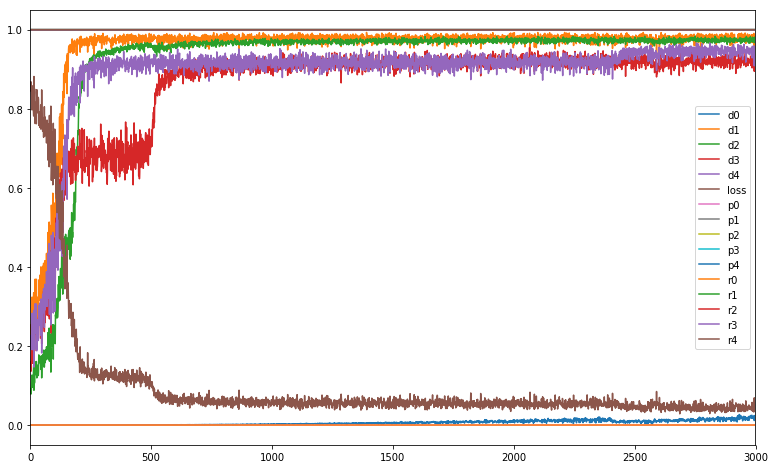

In [20]:
train_metrics.plot(figsize=(13, 8))

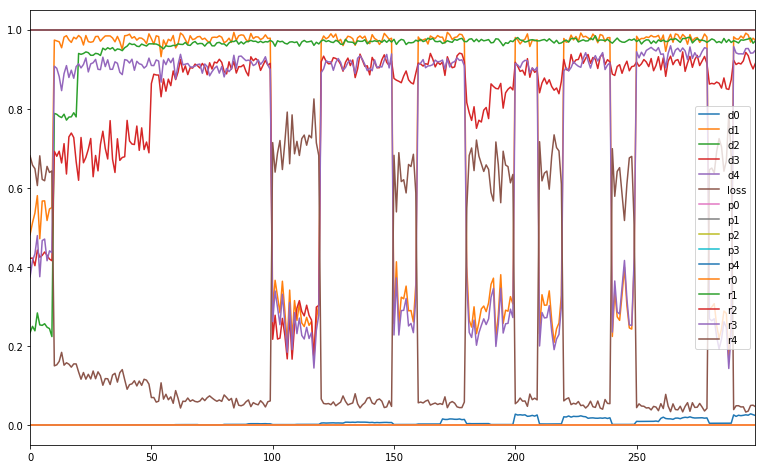

In [21]:
val_metrics.plot(figsize=(13, 8))

## Predict and visualize

In [13]:
torch.save(net, 'models/torch1')

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
test_net = net.cpu()

In [15]:
test_batch = next(iter(val_gen))
test_pred = net(npvar(test_batch[1], False))
test_pred_np = test_pred.cpu().data.numpy()

In [16]:
test_batch[1][0][0]

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]], dtype=float32)

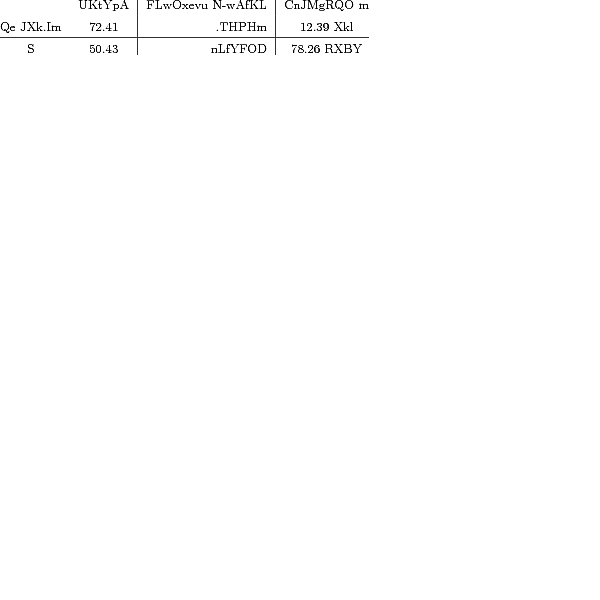

In [17]:
arr_to_img(test_batch[1][0][0])

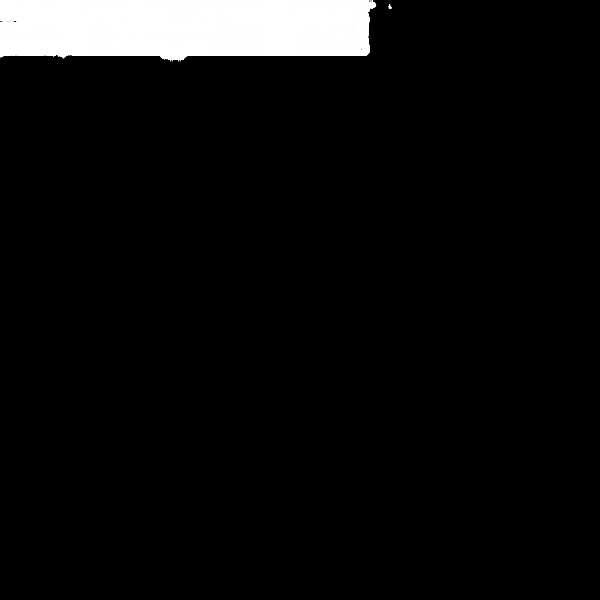

In [18]:
arr_to_img(test_pred_np[0][1])